<a href="https://colab.research.google.com/github/thsdornelas/colab_script/blob/main/02_tese_anadem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import pandas as pd

In [2]:
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=KkdTuTm6uGvKLSquHVW9G1guEURXHmAfLooEc9CWhsg&tc=K5byj1N9Jcwci-67qordp2z7r3JQiMvoyg9-fQGsWa0&cc=Db1bB3LsLwgYhGOulQHzp7Odyt3R2dFhpUO4iUoJJRg

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdLIrYeN2VgSHWB0pUHVs040GLoa7cSK0ba9PGL5bB3zfOtcUN-X_srEpFQ

Successfully saved authorization token.


In [3]:
# Acessa o dado anadem
anadem = ee.Image('projects/et-brasil/assets/anadem/v018')
#anadem

In [4]:
# Remove noData
anadem = anadem.updateMask(anadem.neq(0))

In [8]:
# Importa o TST do MODIS
tst = ee.ImageCollection('MODIS/061/MOD11A1')

In [9]:
# Início
inicial_dt = '2017-01-01'
# Final
final_dt = '2020-01-01' # Até o dia 31/12/2019

# Seleciona a banda LST
tst = tst.select('LST_Day_1km', 'QC_Day').filterDate(inicial_dt,final_dt)

In [11]:
# Pontuais numa área de soja e de Cerradão
soja_whermann_1 = ee.Geometry.Point(-47.473350,-16.193706)
regiao_cerradao = ee.Geometry.Point(-47.99,-15.72)

In [15]:
#Analisando o dado de TST
scale = 1000

# Extrai o dado de elevação da soja
soja_point = anadem.sample(soja_whermann_1, scale).first().get('min1')
#soja_point

# Calcula e apresenta o valor médio da temperatura superficial no ponto
soja_tst = tst.mean().sample(soja_whermann_1, scale).first().get('LST_Day_1km')
#soja_tst



In [18]:
# Trabalhando a serie temporal
tst_soja = tst.getRegion(soja_whermann_1, scale).getInfo()

tst_cerradao = tst.getRegion(regiao_cerradao, scale).getInfo()

# Primeiro cinco resultados
#tst_soja[:5] # A saída é um array com as informações
# Os valores NONE na coluna LST_Day_1km se referem a datas com nuvens. A coluna QC_Day apresenta valor 2 por esse motivo.

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  -47.47147118929612,
  -16.192132996254376,
  1483228800000,
  15404,
  0],
 ['2017_01_02',
  -47.47147118929612,
  -16.192132996254376,
  1483315200000,
  15367,
  0],
 ['2017_01_03',
  -47.47147118929612,
  -16.192132996254376,
  1483401600000,
  15363,
  0],
 ['2017_01_04',
  -47.47147118929612,
  -16.192132996254376,
  1483488000000,
  None,
  2]]

In [19]:
# Transformando o array em dataframe

def ee_array_to_df(array, list_band):
  # Transforma em df
  df = pd.DataFrame(array)

  # Organiza o cabeçalho
  cabecalho = df.iloc[0]
  df = pd.DataFrame(df.values[1:], columns=cabecalho)

  # Remove as linhas com None
  df = df[['longitude', 'latitude', 'time', *list_band]].dropna()

  # Transforma o dado em valores numéricos
  for band in list_band:
    df[band] = pd.to_numeric(df[band], errors='coerce')

  # Converte o campo de tempo em datetime
  df['datetime'] = pd.to_datetime(df['time'], unit='ms')

  # Mantém as colunas de interesse
  df = df[['time','datetime', *list_band]]

  return df


In [20]:
# Aplica a função ee_array_to_df para acessar as duas séries temporais

lst_df_soja = ee_array_to_df(tst_soja, ['LST_Day_1km'])

lst_df_cerradao = ee_array_to_df(tst_cerradao, ['LST_Day_1km'])

# Função para transformar de Kelvin para Celsius
def t_modis_to_celsius(t_modis):
  t_celsius = 0.02 * t_modis - 273.15
  return t_celsius

# Aplicar a função de conversão em celsius
lst_df_soja['LST_Day_1km'] = lst_df_soja['LST_Day_1km'].apply(t_modis_to_celsius) # Soja
lst_df_cerradao['LST_Day_1km'] = lst_df_cerradao['LST_Day_1km'].apply(t_modis_to_celsius) # Cerradão

#lst_df_soja.head()

,time,datetime,LST_Day_1km
0,1483228800000,2017-01-01,34.93
1,1483315200000,2017-01-02,34.19
2,1483401600000,2017-01-03,34.11
6,1483747200000,2017-01-07,31.95
7,1483833600000,2017-01-08,31.87


In [21]:
# Há uma sazonalidade na temperatura de uma área de soja e uma de cerradão?
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [22]:
# Ajuste de curvas
# Extração dos valores no eixo x dos dataframes
x_dt_soja = np.asanyarray(lst_df_soja['time'].apply(float))
x_dt_cerradao = np.asanyarray(lst_df_cerradao['time'].apply(float))

In [23]:
# Extração dos valores do eixo y
y_dt_soja = np.asanyarray(lst_df_soja['LST_Day_1km'].apply(float))
y_dt_cerradao = np.asanyarray(lst_df_cerradao['LST_Day_1km'].apply(float))

In [27]:
# Função para ajustar as curvas por meio dos parâmetros
def fit_fun(t, lst0, delta_lst, tau, phi):
  # lst0 = média anual da LST
  # delta_lst = amplitude entre a LST máxima e mínima
  # tau = período de oscilação da LST
  # phi = representa o offset para ajustar o tempo quando t = lst0
  return lst0 + (delta_lst/2) * np.sin(2*np.pi*t/tau+phi)


In [33]:
# Parâmetros
lst0 = 5
delta_lst = 40
tau = 365*24*3600*1000 #milissegundos em um ano
phi = 2*np.pi*4*30.5*3600*1000/tau # offset

params_soja, params_covariance_soja = optimize.curve_fit(fit_fun,
                                                         x_dt_soja, y_dt_soja, p0 = [lst0, delta_lst, tau, phi])

params_cerradao, params_covariance_cerradao = optimize.curve_fit(fit_fun,
                                                         x_dt_cerradao, y_dt_cerradao, p0 = [lst0, delta_lst, tau, phi])


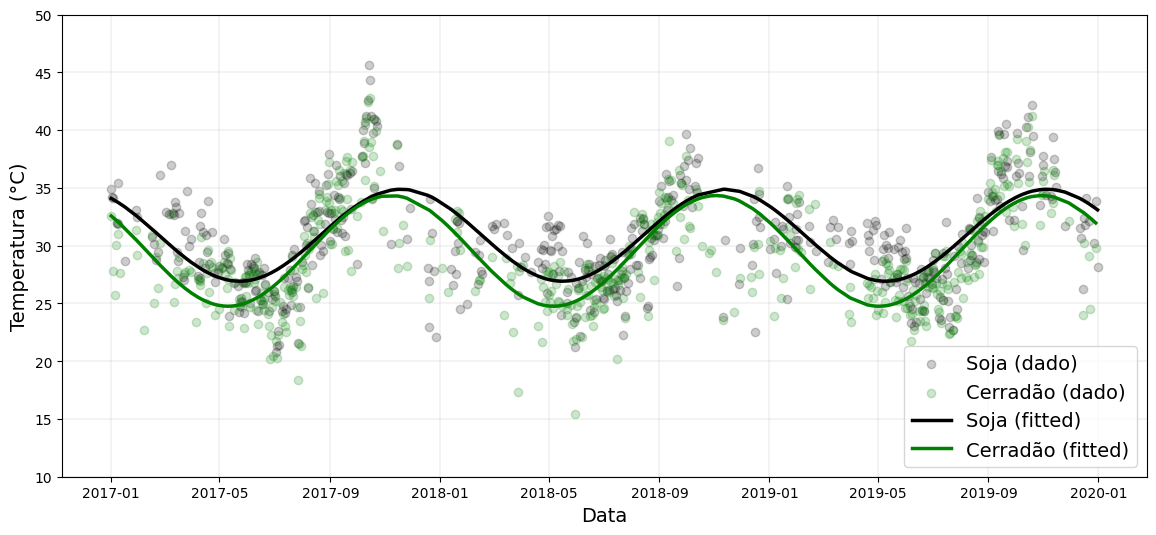

In [38]:
# Subplot
fig, ax = plt.subplots(figsize=(14,6))

# Gráfico de dispersão
ax.scatter(lst_df_soja['datetime'], lst_df_soja['LST_Day_1km'],
           c='black', alpha=0.2, label = 'Soja (dado)')
ax.scatter(lst_df_cerradao['datetime'], lst_df_cerradao['LST_Day_1km'],
           c='green', alpha=0.2, label = 'Cerradão (dado)')

# Adicionar as curvas de ajuste
ax.plot(lst_df_soja['datetime'],
        fit_fun(x_dt_soja, params_soja[0], params_soja[1], params_soja[2], params_soja[3]),
        label= 'Soja (fitted)', color = 'black', lw =2.5)

ax.plot(lst_df_cerradao['datetime'],
        fit_fun(x_dt_cerradao, params_cerradao[0], params_cerradao[1], params_cerradao[2], params_cerradao[3]),
        label= 'Cerradão (fitted)', color = 'green', lw =2.5)

# Parâmetros no gráfico
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Temperatura (°C)', fontsize=14)
ax.set_ylim(10,50)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc = 'lower right')

plt.show()


In [12]:
Map = geemap.Map()
Map.addLayer(anadem, {'min':0, 'max':1300.0, 'palette': ['006600', '002200', 'fff700', 'ab7634', 'c4d0ff', 'ffffff']}, 'Anadem')
Map.addLayer(soja_whermann_1, {'color': 'red'}, 'soja_whermann_1')
Map.addLayer(regiao_cerradao, {'color': 'black'}, 'regiao_cerradao')

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…